# Optimization Methods For Data Science
## Final Project - Part 1: MLP

Géraldine V. Maurer, Viktoriia Vlasenko

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
random.seed(42)
np.random.seed(42)

warnings.filterwarnings('ignore')

from functions_1j_maurer_vlasenko import *

### Import Data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/gmaurer08/Optimization-Final-Project/refs/heads/main/AGE_PREDICTION.csv")
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,gt
0,2.686191,-0.989465,-0.920503,1.607427,-0.896248,1.118974,-0.969456,1.811707,2.560955,3.803463,...,-0.862891,-0.909545,-0.915361,-0.952061,-0.989461,1.911855,1.409705,2.303997,-0.981840,54
1,-0.887917,4.915272,-0.939446,-0.343677,-0.964685,-0.478649,4.342395,-0.332870,-0.768041,-0.815375,...,-0.939201,-0.965917,-0.969461,-0.934799,5.304822,0.934790,-0.410701,0.284690,4.919212,18
2,-0.923215,2.746968,-0.918085,0.047804,-0.908587,-0.451752,2.984481,0.535007,-0.591029,-0.324043,...,-0.809726,-0.929934,-0.891814,-0.881796,3.415373,1.044108,-0.442615,0.033648,2.628199,26
3,-0.268866,-0.408416,-0.935145,0.731800,-0.922438,0.221781,-0.046606,1.149634,0.592136,1.357959,...,-0.834968,-0.937475,-0.917737,-0.929519,-0.226282,1.608048,0.276169,1.246468,-0.363367,33
4,0.529231,-0.829957,-0.897425,0.921280,-0.865304,0.331018,-0.644940,1.296097,1.166863,2.036034,...,-0.775411,-0.881967,-0.864018,-0.908001,-0.784495,1.329586,0.547925,1.195395,-0.810089,35


### Data Preparation

In [3]:
# Separate features and target
feature_cols = [col for col in data.columns if col.startswith('feat')]
X = data[feature_cols].values
y = data['gt'].values

print(f"Features: {len(feature_cols)} columns")
print(f"Data shape: {X.shape}")
print(f"Target range: {y.min():.2f}-{y.max():.2f}")

# Split data into train/test sets
n_total = len(X)
n_train = int(0.8*n_total)    # 80% for training (used with CV inside)
# Remaining 20% for testing

# Shuffle indices
indices = np.random.permutation(n_total)
train_idx = indices[:n_train]
test_idx = indices[n_train:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Features: 32 columns
Data shape: (20475, 32)
Target range: 10.00-89.00
Train set: (16380, 32)
Test set: (4095, 32)


### Find the best hyperparameters with Cross-Validation

In [4]:
# Find best hyperparameters using cross-validation
best_parameters, search_results = hyperparameter_search(X_train, y_train)

Starting hyperparameter search

[1/24] Testing configuration:
Layers: [64, 32] (hidden)
Activation: tanh
Lambda: 0.001

Starting 3-fold cross-validation...

Fold 1/3
Training network with architecture: [32, 64, 32, 1]
Activation: tanh, Lambda: 0.001
Initial loss: 1662.687561
Final loss: 86.543487
Optimization successful: False
Number of iterations: 1000
Train Loss: 83.8020, Val Loss: 104.0971
Train MAPE: 21.4188%, Val MAPE: 24.0400%

Fold 2/3
Training network with architecture: [32, 64, 32, 1]
Activation: tanh, Lambda: 0.001
Initial loss: 1656.307293
Final loss: 85.941984
Optimization successful: False
Number of iterations: 1000
Train Loss: 83.5605, Val Loss: 104.5303
Train MAPE: 21.4481%, Val MAPE: 24.0472%

Fold 3/3
Training network with architecture: [32, 64, 32, 1]
Activation: tanh, Lambda: 0.001
Initial loss: 1655.990383
Final loss: 85.076143
Optimization successful: False
Number of iterations: 1000
Train Loss: 82.1874, Val Loss: 104.1293
Train MAPE: 21.4136%, Val MAPE: 24.2008%
R

### Training the final model with the best hyperparameters

In [14]:
import time
np.random.seed(42)

# Train final model with best parameters
start_time = time.time()
final_weights, final_biases, optimization_result, initial_loss, final_loss = train_network(
    X_train, y_train,
    layer_sizes=best_parameters['layers'],
    activation=best_parameters['activation'],
    lambda_reg=best_parameters['lambda_reg'],
    method='L-BFGS-B',
    maxiter=1000,
    seed=42
)
# Compute time difference from start
end_time = time.time()
optimization_time = end_time - start_time

# For initial loss, we need to re-initialize weights in same way
init_weights, init_biases = initialize_network(best_parameters['layers'])
y_train_pred_init = predict(X_train, init_weights, init_biases, best_parameters['activation'])
y_test_pred_init = predict(X_test, init_weights, init_biases, best_parameters['activation'])

# Final predictions (after training)
y_train_pred_final = predict(X_train, final_weights, final_biases, best_parameters['activation'])
y_test_pred_final = predict(X_test, final_weights, final_biases, best_parameters['activation'])

# Compute Mean Squared Error
train_mse = mean_squared_error(y_train, y_train_pred_final)
test_mse = mean_squared_error(y_test, y_test_pred_final)

# Compute Mean Absolute Percentage Error
train_mape_init = MAPE(y_train, y_train_pred_init)
test_mape_init = MAPE(y_test, y_test_pred_init)
train_mape_final = MAPE(y_train, y_train_pred_final)
test_mape_final = MAPE(y_test, y_test_pred_final)

# Output results
print(f"Number of layers L chosen: {len(best_parameters['layers'])-1}")
print(f"Number of neurons N chosen: {max(best_parameters['layers'][1:-1]) if len(best_parameters['layers'])>2 else best_parameters['layers'][1]}")
print(f"Value of lambda chosen: {best_parameters['lambda_reg']}")
print(f"Other hyperparameters: activation = {best_parameters['activation']}, maxiter = 1000")
print(f"Optimization solver: L-BFGS-B")
print(f"Number of iterations: {optimization_result.nit}")
print(f"Optimization time: {optimization_time:.2f} seconds")
print(f"Training Error (MSE, without regularization): {train_mse:.6f}")
print(f"Test Error (MSE): {test_mse:.6f}")
print(f"Initial Training MAPE: {train_mape_init:.4f}%")
print(f"Initial Test MAPE: {test_mape_init:.4f}%")
print(f"Final Training MAPE: {train_mape_final:.4f}%")
print(f"Final Test MAPE: {test_mape_final:.4f}%")


Training network with architecture: [32, 64, 32, 16, 1]
Activation: sigmoid, Lambda: 0.01
Initial loss: 1675.734443
Final loss: 98.689045
Optimization successful: False
Number of iterations: 1000
Number of layers L chosen: 4
Number of neurons N chosen: 64
Value of lambda chosen: 0.01
Other hyperparameters: activation = sigmoid, maxiter = 1000
Optimization solver: L-BFGS-B
Number of iterations: 1000
Optimization time: 294.31 seconds
Training Error (MSE, without regularization): 95.003767
Test Error (MSE): 91.734070
Initial Training MAPE: 99.2923%
Initial Test MAPE: 99.2925%
Final Training MAPE: 23.3173%
Final Test MAPE: 22.7634%


### Save Results

In [17]:
# Save detailed results
results_summary = {
    'best_config': best_parameters,
    'optimization_result': {
        'success': optimization_result.success,
        'message': optimization_result.message,
        'iterations': optimization_result.nit,
        'optimization_time': optimization_time,
        'initial_loss': initial_loss,
        'final_loss': final_loss
    },
    'performance_metrics': {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_mape_init': train_mape_init,
        'test_mape_init': test_mape_init,
        'train_mape_final': train_mape_final,
        'test_mape_final': test_mape_final
    },
    'hyperparameter_search_results': search_results
}

In [18]:
import pickle
with open("results_summary.pkl", "wb") as f:
    pickle.dump(results_summary,f)
f.close()

### Visualize Results

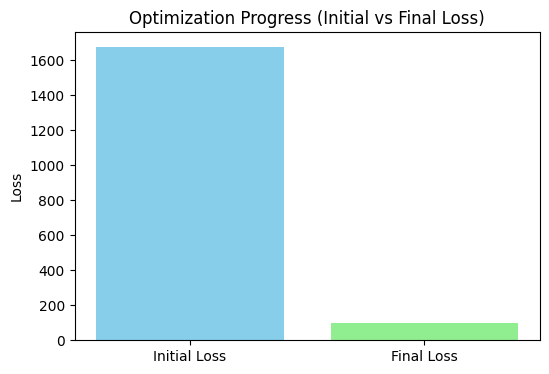

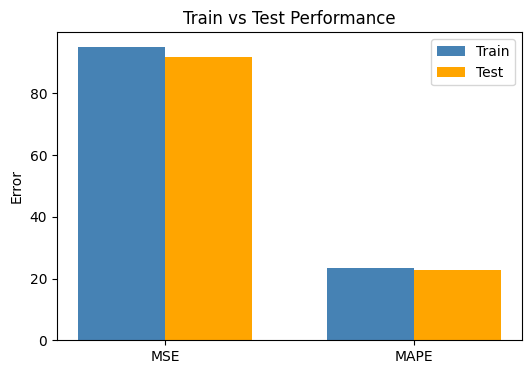

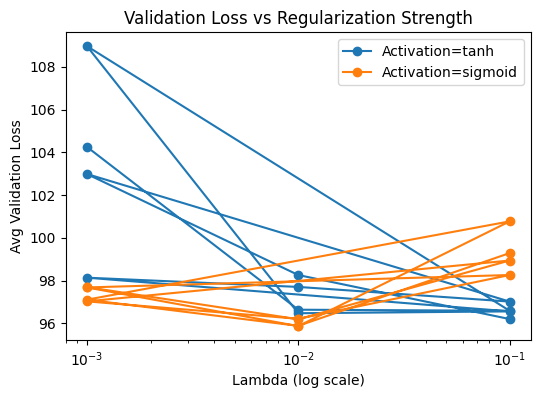

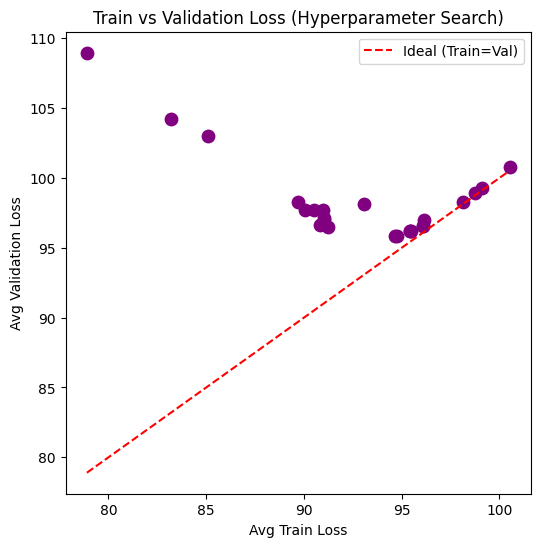

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Initial vs Final Loss
init_loss = results_summary['optimization_result']['initial_loss']
final_loss = results_summary['optimization_result']['final_loss']

plt.figure(figsize=(6,4))
plt.bar(['Initial Loss', 'Final Loss'], [init_loss, final_loss], color=['skyblue','lightgreen'])
plt.title("Optimization Progress (Initial vs Final Loss)")
plt.ylabel("Loss")
plt.show()

# 2. Train vs Test Performance
metrics = results_summary['performance_metrics']
labels = ['MSE', 'MAPE']
train_vals = [metrics['train_mse'], metrics['train_mape_final']]
test_vals = [metrics['test_mse'], metrics['test_mape_final']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x-width/2, train_vals, width, label='Train', color='steelblue')
plt.bar(x+width/2, test_vals, width, label='Test', color='orange')
plt.xticks(x, labels)
plt.title("Train vs Test Performance")
plt.ylabel("Error")
plt.legend()
plt.show()

# 3. Hyperparameter Search: Val Loss vs lambda
search_results = results_summary['hyperparameter_search_results']
lambdas = [res['lambda_reg'] for res in search_results]
val_losses = [res['avg_val_loss'] for res in search_results]
activations = [res['activation'] for res in search_results]

plt.figure(figsize=(6,4))
for act in set(activations):
    xs = [l for l,a in zip(lambdas,activations) if a==act]
    ys = [v for v,a in zip(val_losses,activations) if a==act]
    plt.plot(xs, ys, marker='o', label=f'Activation={act}')
plt.xscale('log')
plt.xlabel("Lambda (log scale)")
plt.ylabel("Avg Validation Loss")
plt.title("Validation Loss vs Regularization Strength")
plt.legend()
plt.show()

# 4. Train vs Validation Loss Scatter
train_losses = [res['avg_train_loss'] for res in search_results]
val_losses = [res['avg_val_loss'] for res in search_results]

plt.figure(figsize=(6,6))
plt.scatter(train_losses, val_losses, c='purple', s=80)
plt.plot([min(train_losses), max(train_losses)],
         [min(train_losses), max(train_losses)], 'r--', label="Ideal (Train=Val)")
plt.xlabel("Avg Train Loss")
plt.ylabel("Avg Validation Loss")
plt.title("Train vs Validation Loss (Hyperparameter Search)")
plt.legend()
plt.show()


In [15]:
results_summary

{'best_config': {'layers': [32, 64, 32, 16, 1],
  'activation': 'sigmoid',
  'lambda_reg': 0.01},
 'optimization_result': {'success': False,
  'message': 'STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT',
  'iterations': 1000,
  'optimization_time': 491.96037006378174,
  'initial_loss': np.float64(1675.7344432251869),
  'final_loss': np.float64(98.68904478467041)},
 'performance_metrics': {'train_mse': 95.00376742942767,
  'test_mse': 91.73407037724682,
  'train_mape': np.float64(23.317300386830812),
  'test_mape': np.float64(22.763386623945472)},
 'hyperparameter_search_results': [{'layers': [32, 64, 32, 1],
   'activation': 'tanh',
   'lambda_reg': 0.001,
   'avg_val_loss': np.float64(104.25221363501898),
   'avg_val_mape': np.float64(24.096009594306775),
   'avg_train_loss': np.float64(83.18331023458138),
   'avg_train_mape': np.float64(21.42685057717213)},
  {'layers': [32, 64, 32, 1],
   'activation': 'tanh',
   'lambda_reg': 0.01,
   'avg_val_loss': np.float64(96.63371678567887),
   